### Import Package

In [0]:
# import wordcloud
!pip install wordcloud

# import gensim
!pip install gensim

     |████████████████████████████████| 458 kB 11.0 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-207bd96d-7167-4224-b284-5d0b6c65aa8f/bin/python -m pip install --upgrade pip' command.
     |███▉                            | 2.9 MB 10.7 MB/s 

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 24.0 MB 10.7 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-207bd96d-7167-4224-b284-5d0b6c65aa8f/bin/python -m pip install --upgrade pip' command.


In [0]:
# upgrade pip
!pip install --upgrade pip

In [0]:
# import libraries
import os
import pandas as pd
import re
import pyspark.sql.functions as f
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col,sum,avg,max,count
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import sys
from collections import ChainMap
import plotly.graph_objects as go
from pyspark.sql.functions import array_remove
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.sql.functions import collect_list
from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.types import ArrayType,StringType,IntegerType
from gensim.models import Word2Vec
import gensim
from gensim.utils import simple_preprocess
import requests
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM,Flatten
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn import metrics

### Read File

In [0]:
# read from submission data
ml_df = spark.read.parquet("/FileStore/ML_preparing")
ml_df.printSchema()

root
 |-- idx: long (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: long (nullable = true)
 |-- hide_score: boolean (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- gilded: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- selftext: string (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- disable_comments: boolean (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- result: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- text_length: integer (nullable = true)



In [0]:
# start pyspark
spark = sparknlp.start()
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 4.2.1
Apache Spark version: 3.3.0


In [0]:
ml_df = ml_df.select('subreddit','result')
ml_df.show()

+---------------+--------------------+
|      subreddit|              result|
+---------------+--------------------+
|      Minecraft|[world, villages,...|
|      Minecraft|[beehiveshttpspre...|
|      Minecraft|  [forge, 189, dead]|
|      Minecraft|[old, minecraft, ...|
|leagueoflegends|[lookbacklolcomht...|
|      Minecraft|[need, help, unab...|
|leagueoflegends|[high, elo, absol...|
|      Minecraft|[love, biomes, o,...|
|      Minecraft|[say, unable, joi...|
|      Minecraft|[news, workaround...|
|      Minecraft|[best, survival, ...|
|      Minecraft|      [change, mind]|
|      Minecraft|[every, time, try...|
|      Minecraft|[making, cactus, ...|
|leagueoflegends|[personally, enjo...|
|      Minecraft|[please, helphttp...|
|      Minecraft|[son, minecraft, ...|
|      Minecraft|[went, end, porta...|
|leagueoflegends|[put, esports, kn...|
|leagueoflegends|[mortred, phantom...|
+---------------+--------------------+
only showing top 20 rows



### Clean Data

In [0]:
# drop words which has extremely long length
ml = ml_df.withColumn("text", f.expr("filter(result, x -> not(length(x) >= 15))")).drop("result")
ml.show()

+---------------+--------------------+
|      subreddit|                text|
+---------------+--------------------+
|      Minecraft|[world, villages,...|
|      Minecraft|[beehives, bit, b...|
|      Minecraft|  [forge, 189, dead]|
|      Minecraft|[old, minecraft, ...|
|leagueoflegends|[go, website, del...|
|      Minecraft|[need, help, unab...|
|leagueoflegends|[high, elo, absol...|
|      Minecraft|[love, biomes, o,...|
|      Minecraft|[say, unable, joi...|
|      Minecraft|[news, workaround...|
|      Minecraft|[best, survival, ...|
|      Minecraft|      [change, mind]|
|      Minecraft|[every, time, try...|
|      Minecraft|[making, cactus, ...|
|leagueoflegends|[personally, enjo...|
|      Minecraft|            [please]|
|      Minecraft|[son, minecraft, ...|
|      Minecraft|[went, end, porta...|
|leagueoflegends|[put, esports, kn...|
|leagueoflegends|[mortred, phantom...|
+---------------+--------------------+
only showing top 20 rows



In [0]:
# change labels to 0 and 1
stateDic={'leagueoflegends':0,'Minecraft':1}
ml_label=ml.rdd.map(lambda x: 
    (stateDic[x.subreddit],x.text) 
    ).toDF(["label","text"])
ml_label.show()

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    1|[world, villages,...|
|    1|[beehives, bit, b...|
|    1|  [forge, 189, dead]|
|    1|[old, minecraft, ...|
|    0|[go, website, del...|
|    1|[need, help, unab...|
|    0|[high, elo, absol...|
|    1|[love, biomes, o,...|
|    1|[say, unable, joi...|
|    1|[news, workaround...|
|    1|[best, survival, ...|
|    1|      [change, mind]|
|    1|[every, time, try...|
|    1|[making, cactus, ...|
|    0|[personally, enjo...|
|    1|            [please]|
|    1|[son, minecraft, ...|
|    1|[went, end, porta...|
|    0|[put, esports, kn...|
|    0|[mortred, phantom...|
+-----+--------------------+
only showing top 20 rows



In [0]:
# bonus:
# pipeline: change text to vectors
count = CountVectorizer(inputCol="text", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
pipeline = Pipeline(stages=[count, idf])

In [0]:
pipelineModel = pipeline.fit(ml_label)
rescaledData = pipelineModel.transform(ml_label)
rescaledData.select("label", "features").show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(229160,[4,13,27,...|
|    1|(229160,[175,713,...|
|    1|(229160,[356,948,...|
|    1|(229160,[0,1,5,6,...|
|    0|(229160,[33,34,38...|
|    1|(229160,[13,22,30...|
|    0|(229160,[29,196,3...|
|    1|(229160,[15,26,27...|
|    1|(229160,[4,13,57,...|
|    1|(229160,[4,39,47,...|
|    1|(229160,[0,22,25,...|
|    1|(229160,[96,485],...|
|    1|(229160,[7,13,18,...|
|    1|(229160,[45,110,3...|
|    0|(229160,[11,342,5...|
|    1|(229160,[57],[2.7...|
|    1|(229160,[1,2,4,15...|
|    1|(229160,[4,5,7,16...|
|    0|(229160,[3,6,7,16...|
|    0|(229160,[3,6,9,17...|
+-----+--------------------+
only showing top 20 rows



### Split to Train/Test Data

In [0]:
rescaledData.na.drop()
rescaledData = rescaledData.withColumn("size", f.size(f.col('text')))
rescaledData = rescaledData.filter(f.col("size") >= 1)

from pyspark.sql.window import Window as W
windowSpec = W.orderBy("idx")
rescaledData_idx = rescaledData.withColumn("idx", monotonically_increasing_id())
rescaledData_idx = rescaledData_idx.withColumn("idx", f.row_number().over(windowSpec))
rescaledData_idx.show()

+-----+--------------------+--------------------+--------------------+----+---+
|label|                text|         rawFeatures|            features|size|idx|
+-----+--------------------+--------------------+--------------------+----+---+
|    1|[world, villages,...|(229160,[4,13,27,...|(229160,[4,13,27,...|  28|  1|
|    1|[beehives, bit, b...|(229160,[175,713,...|(229160,[175,713,...|   8|  2|
|    1|  [forge, 189, dead]|(229160,[356,948,...|(229160,[356,948,...|   3|  3|
|    1|[old, minecraft, ...|(229160,[0,1,5,6,...|(229160,[0,1,5,6,...| 101|  4|
|    0|[go, website, del...|(229160,[33,34,38...|(229160,[33,34,38...|  21|  5|
|    1|[need, help, unab...|(229160,[13,22,30...|(229160,[13,22,30...|  30|  6|
|    0|[high, elo, absol...|(229160,[29,196,3...|(229160,[29,196,3...|   8|  7|
|    1|[love, biomes, o,...|(229160,[15,26,27...|(229160,[15,26,27...|  38|  8|
|    1|[say, unable, joi...|(229160,[4,13,57,...|(229160,[4,13,57,...|   9|  9|
|    1|[news, workaround...|(229160,[4,3

In [0]:
trainDF_temp, testDF_temp = rescaledData_idx.select("idx").randomSplit(weights = [0.80, 0.20], seed = 12)
trainDF_temp = rescaledData_idx.join(trainDF_temp, on="idx", how="inner")
testDF_temp = rescaledData_idx.join(testDF_temp, on="idx", how="inner")

trainDF = trainDF_temp.select("label", "features")
testDF = testDF_temp.select("label", "features")

trainDF.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(229160,[4,13,27,...|
|    1|(229160,[356,948,...|
|    1|(229160,[0,1,5,6,...|
|    0|(229160,[33,34,38...|
|    1|(229160,[13,22,30...|
|    0|(229160,[29,196,3...|
|    1|(229160,[4,13,57,...|
|    1|(229160,[4,39,47,...|
|    1|(229160,[0,22,25,...|
|    1|(229160,[96,485],...|
|    1|(229160,[7,13,18,...|
|    1|(229160,[45,110,3...|
|    0|(229160,[11,342,5...|
|    1|(229160,[57],[2.7...|
|    1|(229160,[1,2,4,15...|
|    1|(229160,[4,5,7,16...|
|    0|(229160,[3,6,7,16...|
|    0|(229160,[6,7,10,1...|
|    1|(229160,[7,30,32,...|
|    1|(229160,[1,2,15,1...|
+-----+--------------------+
only showing top 20 rows



### Fit to Logistic Regression

In [0]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=1)
lrModel = lr.fit(trainDF)

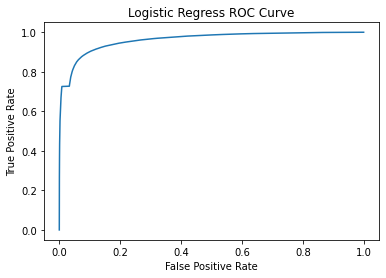

Training set areaUnderROC: 0.9617741528847199
<Figure size 432x288 with 0 Axes>

In [0]:
# Plot ROC Curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regress ROC Curve')
plt.show()
plt.savefig('../../data/plots/LR_ROC.png', dpi=160, bbox_inches='tight')

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Check Test Data

In [0]:
predictions = lrModel.transform(testDF)
predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|(229160,[175,713,...|[-3.7151888276003...|[0.02377197495012...|       1.0|
|    1|(229160,[15,26,27...|[-4.0658691014711...|[0.01685898024304...|       1.0|
|    0|(229160,[3,6,9,17...|[12.8511054837230...|[0.99999737678031...|       0.0|
|    0|(229160,[3,6,16,2...|[29.0495128184087...|[0.99999999999975...|       0.0|
|    1|(229160,[40,134,1...|[-3.0977491299187...|[0.04320019666759...|       1.0|
|    0|(229160,[2,3,26,2...|[2.18167794633421...|[0.89859207617851...|       0.0|
|    0|(229160,[0,5,16,2...|[2.09226066193483...|[0.89014867727433...|       0.0|
|    0|(229160,[0,23,45,...|[-0.0267649526986...|[0.49330916124285...|       1.0|
|    1|(229160,[17,30,47...|[-3.3179999880075...|[0.03495881961670...|       1.0|
|    1|(229160,[

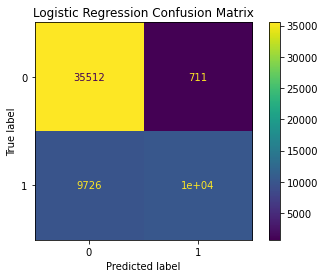

In [0]:
# confusion matrix
l = testDF.select('label').rdd.flatMap(lambda x: x).collect()
predict = lrModel.transform(testDF).select('prediction').rdd.flatMap(lambda x: x).collect()
predict = [int(i) for i in predict]
m = confusion_matrix(l, predict,labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=m,
                              display_labels=[0,1]).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [0]:
metrics.log_loss(l, predict)

Out[16]: 6.42525596859975

In [0]:
metrics.accuracy_score(l,predict)

Out[17]: 0.8139737991266376

In [0]:
metrics.roc_auc_score(l, predict)

Out[18]: 0.745592694270794

In [0]:
# get accuracy
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
predictionAndTarget = lrModel.transform(testDF).select('label','prediction')
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
acc

Out[19]: 0.8139737991266376

In [0]:
lrModel.save('/dbfs/FileStore/lrML_model/lrmodel')

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-2354755412609217> in <cell line: 1>()
----> 1 lrModel.save('/dbfs/FileStore/lrML_model/lrmodel')

/databricks/spark/python/pyspark/ml/util.py in save(self, path)
    337     def save(self, path: str) -> None:
    338         """Save this ML instance to the given path, a shortcut of 'write().save(path)'."""
--> 339         self.write().save(path)
    340 
    341 

/databricks/spark/python/pyspark/ml/util.py in save(self, path)
    288         if not isinstance(path, str):
    289             raise TypeError("path should be a string, got type %s" % type(path))
--> 290         self._jwrite.save(path)
    291 
    292     def overwrite(self) -> "JavaMLWriter":

/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1319 
   1320         answer = self.gateway_client.send_command(command)

### LSTM Model

In [0]:
# Use word2vec model, creat word-embedding for all the data
sentence = ml.select('text').rdd.flatMap(lambda x: x).collect()
model = Word2Vec(sentences=sentence, vector_size=10, window=5, min_count=3, workers=4)

# Use the word-embedding tranform each word to a vector that has size of 10, and drop word that reraly appear in the text.

del sentence
ml_pd = ml.toPandas()
def f(x):
    l = []
    for i in x:
        try:
            l.append(model.wv[i])
        except KeyError:
            pass
    return np.array(l)
ml_pd['vec']= ml_pd['text'].apply(f)


In [0]:
train_idx = trainDF_temp.select('idx').rdd.flatMap(lambda x: x).collect()
test_idx =  testDF_temp.select('idx').rdd.flatMap(lambda x: x).collect()

In [0]:
#convert labels to 1 and 0 
labels=ml_pd['subreddit'].apply(lambda f:[1,0] if f == 'Minecraft' else [0,1]).to_list()
labels = np.array([np.array(xi,dtype='float32') for xi in labels])
#Padding the traning data so each sentence has the same length
ready_data = pad_sequences(ml_pd['vec'].to_list(),maxlen=50,padding='post',dtype='float32')
#split train test set
x_train = ready_data[train_idx]
x_test = ready_data[test_idx]
y_train = labels[train_idx]
y_test = labels[test_idx]

In [0]:
# Create a LSTM model using keras, which consist a LSTM layer and a fully connected layer.
model = Sequential()
model.add(LSTM(32, dropout = 0.3, recurrent_dropout = 0.3))
model.add(Dense(16, activation = 'relu'))
model.add(Flatten())
model.add(Dense(2, activation = 'softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.RMSprop(),
    metrics=['accuracy']
)

In [0]:
# Train the LSTM model
history = model.fit(x_train, y_train, epochs=10,batch_size=64, validation_split=0.2,verbose=1)

Epoch 1/10
 372/2800 [==>........

*** WARNING: max output size exceeded, skipping output. ***

2800/2800 [==============================] - 71s 25ms/step - loss: 0.0790 - accuracy: 0.9720 - val_loss: 0.0676 - val_accuracy: 0.9764


In [0]:
#Save the model
model.save('/dbfs/FileStore/ML_model/LSTM')

In [0]:
#Run the model on the test set, the result indicates there's no overfit
model.evaluate(x_test, y_test, batch_size=128)

439/439 [==============================] - 2s 5ms/step - loss: 0.0652 - accuracy: 0.9770
Out[27]: [0.06519103050231934, 0.9770073890686035]

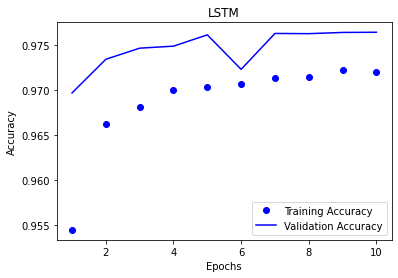

In [0]:
#plot to show the training process
hd = history.history
loss = hd['accuracy']
val_loss = hd['val_accuracy']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss,'bo',label='Training Accuracy')
plt.plot(epochs, val_loss,'b',label='Validation Accuracy')
plt.legend()
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

1754/1754 [==============================] - 7s 4ms/step


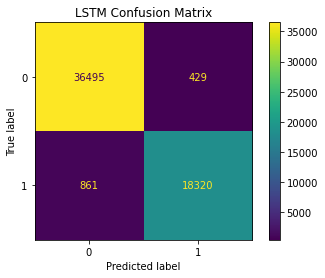

In [0]:
# confusion matrix
predict = model.predict(x_test)
m = confusion_matrix(np.argmax(y_test,axis=-1), np.argmax(predict,axis=-1),labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=m,
                              display_labels=[0,1]).plot()
plt.title("LSTM Confusion Matrix")
plt.show()

3300/7000 [=============>................] - ETA: 13s

*** WARNING: max output size exceeded, skipping output. ***

7000/7000 [==============================] - 26s 4ms/step


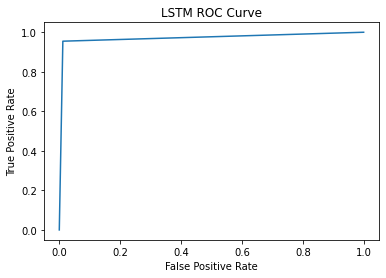

In [0]:
predict = model.predict(x_train)
fpr, tpr, _ = metrics.roc_curve(np.argmax(y_train,axis=-1), np.argmax(predict,axis=-1))

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('LSTM ROC Curve')
plt.show()

In [0]:

metrics.roc_auc_score(np.argmax(y_train,axis=-1), np.argmax(predict,axis=-1))

Out[41]: 0.9715349848830628

In [0]:
metrics.log_loss(np.argmax(y_test,axis=-1), np.argmax(predict,axis=-1))

Out[32]: 0.7941424931241847